# Headline
body



* Look at input data
* Talk about determanism
* Talk about NNs
* Talk about CNNs
* Look at spessific data from project
* Link to pdf


## Converting raw data to something usable
The dataset that was used for this project was the LIDC-IDRI dataset for finding cancerous lung nodules using Computational Tomography (CT). This dataset uses a mixture of dcm and xml files where the dcm file contains the information of a slice of the lung scan while the xml contains the predictions made by the radiologists. CT scans are a type of technology that uses multiple x-rays to determine the density of the insides of an object. The output of a CT scan is a 3-Dimentinal (3D) image of the scanned object. A 3D image is simply an array of images stacked together. In some sense it can be considered like a movie where each frame in the movie correlates to a position within the scanned object and as you progress through the movie you progress through the object. Further on in this document, you will be able to see a CT scan that has been encoded as a movie.

In order to train a Convolutional Neural Network (CNN) on the dataset, we first must do some small changes. CNNs are what is known as Supervised Learning (SL) algorithms and require labeled data for training. To do this, each of the slices (or images) are coupled with the most severe output given by any of the radiologists. The decision to use the most severe case rather than the average, least severe, or any other combination was to make the model as sensitive as possible. The aim of the model is to highlight areas that needs further investigation. The last step is to apply any pre-processing steps to the images as needed to either highlight areas of high importance or remove areas of low importance. The images that are coupled with a class and pre-processed are then written to a file on the disk together with its classification. This is done as during the training the model will use the same image multiple times for training. If the model would have to read, convert and process the image for each time it wanted to train with that image, the training time would be significantly slower. In the following code block, the input files will be assigned a class and written to file, note: No pre-processing will be performed at this time



In [1]:
# importing matplotlib and nympy before anything else
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow and os
import tensorflow as tf
import os
# avoid printing depricated warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import local libraries
from FileConverter import *
from process import preprocess

path = "raw_data/"			# Sets the location of the input data.
output_path = "dataset/"	# Sets the location of the output data.
output_size = 512			# Sets the size of the output image.

# get all the files in the input directiory
folder = glob.glob(os.path.join(path + "*" + "/"))
objs = []

# create the output directory if it does not exist
if not os.path.exists('{}'.format(output_path)):
    os.makedirs('{}'.format(output_path))

# go through all the input files
i = 0
for fold in folder:
    for obj in get_obj(fold):
        # save the object to file
        np.save('{}{}.npy'.format(output_path, str(i).zfill(10)), [obj])
        i += 1
print("Converted {} files".format(i))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Converted 171 files


## Investigating the files
Now that we have converted the CT scan from the original dcm file to a numpy array file, we can load the files from disk using the following commands. 

In [2]:
from Model import *

# get all the files in the output directiory
folder = glob.glob(os.path.join(output_path))

# initiallize an array for the image (x) and label (y) data
x = np.asarray([])
y = np.asarray([])

# go through all the output files
i = 0

filenames = get_files_in_folder(folder[0])

shape = (output_size, output_size, len(filenames))

for file in filenames:
    x, y = read_file(file, x, y, None, None, shape, output_size)

# reshape the image to the correct dimentions
x = x.reshape(shape) # 512, 512, 171
x = x.reshape(len(filenames), output_size, output_size)  # 171, 512, 512 

Having now loaded the files back into memory, we are able to investigate what they look like. The images we have loaded are all from one patient, identified by LIDC-IDRI-0001. The first thing needed to be investigated is the state of our patient. The y array contains the information classified by radiologists for each of the slices of the image. The information is stored in a single number but corresponds to two values. The first value is the nodule class and the second value is the malignancy value. This means that the value 00 has a nodule class of 0 and malignancy of 0 and likewise a nodule class of 14 has a nodule class of 1 and malignancy of 4. 

The nodule class can be between 0 and 3 and each value has a meaning. A value of zero means that there has been no mention of any growths by any of the radiologists, a value of one is a potentially cancerous and large nodule and a value of two is a small nodule (benign cyst) and lastly a value of 3 is a non-nodule, likely a shadow or similar that has been noted but is not suspected as a nodule of any kind  

Next, the malignancy of the nodule corresponds to how likely the nodule is cancerous with 0 being no cancer, 1 being highly unlikely and 5 being highly suspicious for cancer. This is the most important feature.

Each slice in the CT scan of the patient has a malignancy and nodule class number tied to it. Due to this, a multitude of the patients will contain a variety of different classifications. This is to teach the model not only what patients have cancer but also to teach it where the cancer is. In the patient we look at in this document, there is cancer present and below the y (expected classes) arrays unique values are printed.


In [3]:
print(np.unique(y))

[ 0. 14. 15. 20. 30.]


As you can see, there is more than just one value present, this patient has some benign cysts but also some cancerous cysts with the malignancy value of 4 and 5. 

The data from the LIDC-IDRI is not ordered, meaning that the data in 0000001 and 0000002 may be in completely different parts of the body. For this reason, a object called order can be called which contains the z-position of the images. As seen in the cell below, when printing order 0, 1, 2 and 3, they correspond to two positions very var away from each other except for 2 and 3 which are in the same spot. The reason 2 and 3 are in the same spot is since there is a nodule with a malignancy score in that spot. Those spots will be repeated for each of the radiologists that has looked at this patient.


In [4]:
print("\t\t\torder[0]\torder[1]\torder[2]\torder[3]\t")
print("orders\t\t=\t", order[0][1], "\t", order[1][1], "\t", order[2][1], "\t", order[3][1])
print("classifications\t=\t", y[0], "\t\t", y[1], "\t\t", y[2], "\t\t", y[3], )

			order[0]	order[1]	order[2]	order[3]	
orders		=	 -207.500000 	 -137.500000 	 -112.500000 	 -112.500000
classifications	=	 0.0 		 0.0 		 15.0 		 15.0


In a 3D space, you have a x, y and z position, where x is the left to right, y is the forwards and backwards and z is the up and down position. Using this z-data, we can order the image array to be from the top to the bottom of the lungs or vice versa. In the following cell, the data is sorted using the z-position.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import io

# define a sorting rule for sorting by the second element in array
def sort_by_second_element(elem):
    return int(elem[1])

# add the z-pos data to the array for sorting, the z possition is the vertical possition of the slice. 
xz = [[x[0], order[0][1]]]
last = 0
for i in range(len(x)):
    # there are duplicate images wherever cancerous nodules exists, this removes those.
    if order[i][1] not in np.asarray(xz)[:, 1]:
        xz.append([x[i], order[i][1]])
        last = order[i][1]

# sort the array by the order list
xz.sort(key=sort_by_second_element)

In computers, normally images are stored as pixels, where each pixel is a value between 0 and 255 and in color images there are 3 layers of those values per pixel. Each one of those layers will correlate to red, green and blue, where 0 is no value of that color present and 255 is as much of that color as possible is present. The CT scan images does not follow the rules of normal images and uses a much larger scale that allows for negative values, so displaying them as images to users will cause them to look very unrecognizable. To counter this, Matplotlib has a built-in color map for CT scans and x-rays which can be used to create new images which has the values computer algorithms expect them to have. In the next cell, the images will be formatted using this color map, which takes a while. It will also print the max values of the array before its converted and after its converted so that you can see the change.

In [6]:
def ct_format_img (img):
    """
    converts a CT image to a normal image using the plt.cm.bone cmap from matplotlib
    """
    buffer_ = io.BytesIO()
    plt.imshow(img, cmap=plt.cm.bone)
    plt.axis('off')
    plt.savefig(buffer_, format="png", bbox_inches='tight', dpi=155.339805826) # 155.339805826 to get 500x500 output images
    buffer_.seek(0)
    image = PIL.Image.open(buffer_)
    ar = np.asarray(image)
    plt.close()
    buffer_.close()
    return ar

# print the min and max values before the formatting, note [0][0] as the array contains the image and the z-pos
print("min = {}, max = {}".format(np.min(xz[0][0]), np.max(xz[0][0]))) 
# remove the z-pos data and formats it with the bone cmap. (this is really slow) 
xz = np.asarray(xz)
x2 = []
for i in range(len(xz)):
    x2.append(ct_format_img(xz[i][0]))
x2 = np.asarray(x2)
print("min = {}, max = {}".format(np.min(x2[0]), np.max(x2[0]))) 

min = -1024.0, max = 2440.0
min = 0, max = 255


In the next cell the original image before it has been converted is displayed on the left and on the right the output using the colormap is displayed.

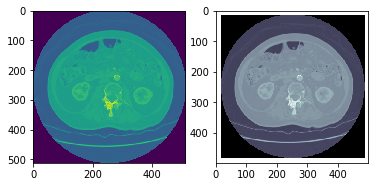

In [7]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(xz[0][0])
f.add_subplot(1,2, 2)
plt.imshow(x2[0])
plt.show(block=True)

If you have ever seen an x-ray or the likes before, the right image should be more recognizable to you. The changing of the values like this is important, in order to make the output images adhere to the industry standard. 

Now, as previously mentioned, the patient discussed in this document has a cancerous cyst. In the image plotted below, there is a mass growing on the bottom right corner, highlighted with a red circle. This is the type of mass that we want to be able to detect automatically.


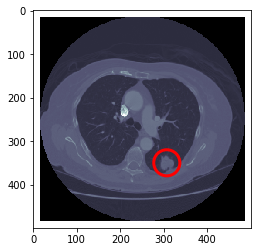

In [8]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)
ax.imshow(x2[90])
circ = Circle((307,350),30, fill=False, edgecolor="r", linewidth=3)
ax.add_patch(circ)
plt.show()

## Image Pre-Processing

But before looking more into the steps that can be taken in order to improve accuracy, a video representation of the CT scan will be created and shown in the cell below as previously promised. Understanding what your dataset is and how it looks is very important before designing an image pre-processing procedure. A pre-processing procedure is steps that are taken prior to training your model on data, in order to help the model, find what its looking for. In many ways, it often boils down to trying to refine the information to highlight important parts and remove or downplay redundant or un-useful parts. In these images, the tissue that is most interesting is the inner soft lung tissue (the darker inner blob), the surrounding tissue, as seen as slightly more white-ish-blue, is less important. This outer white tissue is flesh and cancer is less likely to manifest itself in it. Therefore, if we can crop the image down to only containing the spongy soft tissue, it will likely increase the performance of the model as there is less distracting information and more information that is important and useful per pixel. 

Therefore, understanding the dataset is important. If you write a processing procedure for a dataset that you do not understand, chances are you will do more damage than actual good. Even when you do understand and make reasoned decisions, sometimes they backfire, and the result will give less satisfactory results than the original image. In the next cell, all the images are animated as a movie, played back at ~18 frames per second.


In [9]:
from IPython.display import HTML
from matplotlib import animation

def init():
    im.set_data(x2[0,:,:,:])

def animate(i):
    im.set_data(x2[i,:,:,:])
    return im

# create the figure
fig = plt.figure(figsize=(10,10))
plt.axis('off')
im = plt.imshow(x2[0,:,:,:])
plt.close()

# create an animation of the figure
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=x2.shape[0], interval=55)

# show that animation as a video, using some html5 and css to make it autoplay and be the right size and location 
HTML( '<div style="width: 473px; overflow:hidden; display:block; height: 473px;">' 
     + anim.to_html5_video()\
    .replace('width="720"', 'width="658"')\
    .replace('height="720"', 'height="658"')\
    .replace("controls", 'playsinline style="margin-left: -100px; margin-top: -90px; margin-bottom: -500px;"') 
     + "</div>")

When looking at this vide, in the bottom right corner, there is a sizable cancer nodule that show up towards the end of the video loop.  

In the next cell we run all the processing steps at once and get the output of each of the steps along the way. Each of these images will be plotted, starting with the unaltered version.

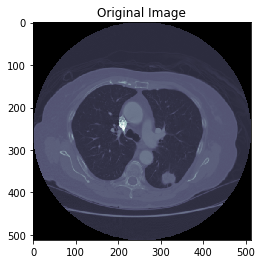

In [10]:
from process import preprocess_return_all
thresh, flood, crop, resized, tozero, morphed, max_morphed = preprocess_return_all(x[2], (358, 358, 1))


plt.imshow(x[2], cmap=plt.cm.bone)
plt.title("Original Image")
plt.show()

This is the starting point, the original image.

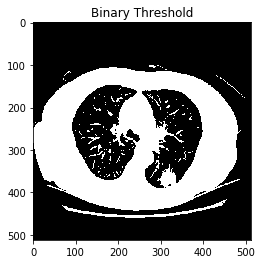

In [11]:
plt.imshow(thresh, cmap=plt.cm.bone)
plt.title("Binary Threshold")
plt.show()

This image looks drastically different than the original. The process that has happened here is called binary threshold and is an algorithm that looks at all the pixels and if a value is below 127 then it will become 0 and if its above it will become 255. This causes the flesh, bone and cancer nodules to be white and soft tissue and air to become black.  

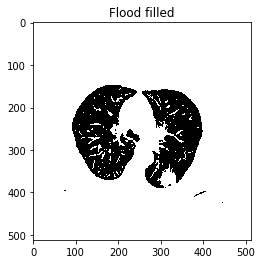

In [12]:
plt.imshow(flood, cmap=plt.cm.bone)
plt.title("Flood filled")
plt.show()

Here, the image has been flood filled from each of its four corners. The way this works is equivalent to the paint bucket in Microsoft Paint, where it will change all connected pixels to a color of your choice. This will essentially delete the tissue surrounding the lungs, virtually leaving only the soft spongy lung tissue.  

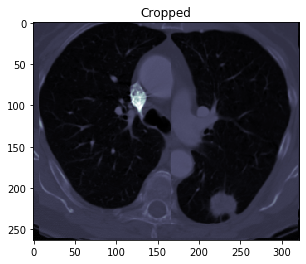

In [13]:
plt.imshow(crop, cmap=plt.cm.bone)
plt.title("Cropped")
plt.show()

Using the image that has been flood filled, we can find the upper, lower, left most and rightmost boundaries of the soft lung tissue. This will be used in order to remove the unwanted tissue surrounding the lungs and leave only the softer spongy tissue on the inside. Notice how this image is no longer 512x512 pixels but instead around 270x330 pixels.   

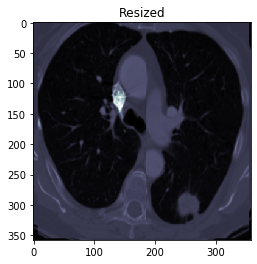

In [14]:
plt.imshow(resized, cmap=plt.cm.bone)
plt.title("Resized")
plt.show()

Most machine learning models does not deal well with inputs of unknown sizes. This is due to the design of the model where it has a set size for inputs and anything outside of that range will not be allowed. This is like how much more difficult life would be if every day when you woke up you had a different size of vision, sometimes you may see things super clearly and other days you may have next to no vision at all. This would make learning new skills very difficult if you were a newborn. CNNs are one of those models that require a set size for its input. To deal with this, each image must be resized to a set size. The size that it will be resized to can be changed in the parameters, however, in most cases its advantageous to follow this base rule: 

$$\frac{(x_{hw}* 0.7)}{32}* 32$$

where $x_{hw}$ is the height or width of the image. Provided an input image with a size where height=width=512, this should look like this:

$$\frac{(512* 0.7)}{32}* 32 = 358$$

The image above has been resized to 358x358 from its original 512x512 origin.


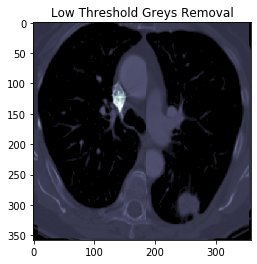

In [15]:
plt.imshow(tozero, cmap=plt.cm.bone)
plt.title("Low Threshold Greys Removal")
plt.show()

In this image there is seemingly very little change, however if you look closely at the black spongy tissue, there is a slight difference. A similar process to the previous binary threshold has been performed here where the colors below a certain value has been converted to pure black but anything above will stay the same. This will remove some of the smaller vessels within the tissue.

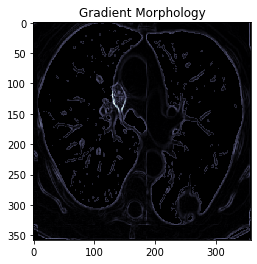

In [16]:
plt.imshow(morphed, cmap=plt.cm.bone)
plt.title("Gradient Morphology")
plt.show()

In this processing step there is quite drastic change, an algorithm called gradient morphology. Gradient morphology uses two other morphological operations in order to create an outline of the object. The first one is dilation, which makes darker objects expand which is applied to a copy of the image and the other one is erosion which makes lighter objects expand which is applied to another copy of the image. Next these the dilation image is subtracted from the erosion image which will leave only the outlines of the image.

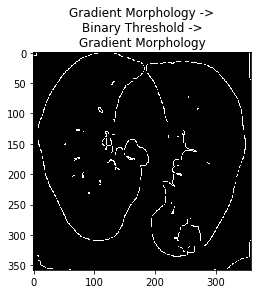

In [17]:
plt.imshow(max_morphed, cmap=plt.cm.bone)
plt.title("Gradient Morphology ->\nBinary Threshold ->\nGradient Morphology")
plt.show()

In this last image, the first step is another gradient morphology which will cause the objects to shrink slightly, then a binary threshold which leaves only black and white pixels and lastly another gradient morphology in order to get rid of any larger sections. 

## Training
Now that the images have been pre-processed, they can be fed into a CNN in order to train it to detect the cancerous lung nodules. First, we will need to import the needed libraries, set up the environment variables and seed the random seeds. 

In programming, libraries are sets of code that other people or you yourself have written previously. In python you import a whole library using the import syntax and parts of a library using the from x import y syntax. The environment variables set here are all for TensorFlow. In Keras, which is a Python library, TensorFlow is one of the 'engines' that you can use. If you imagine the workflow as a website, Keras is like a web browser, making every page look nice while TensorFlow is the actual code that is run in the background. The environment variables set are for deterministic values. This will be further explained . Lastly seeding a random number generator means that you force the random number generator to create the same sequence for each time its run. This means that each number you get is random, however if you restart the program, you will get the same sequence the next time you run it.


In [18]:
import numpy as np
import random
import os
from keras import backend as K
from Model import *

# an effort to make TF deterministic on both cpu and gpu
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TF_CUDNN_USE_AUTOTUNE'] = '0'
os.environ['TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC'] = '1'


import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

from Model import __seed__
seed_value = __seed__

# set random seed in tensor flow
tf.set_random_seed(seed_value)

# set random seed in numpy
np.random.seed(seed_value)

# set random seed in random
random.seed(seed_value)

# set the sh seed for python
os.environ['PYTHONHASHSEED']=str(seed_value)

# create a new global tf session with the aim of increasing determinism of tf operations (not yet compatible with GPU)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


from Utils import *
from zero_rule import ZeroRule
from Model import __version__


### Determinism
In most science, it is important for results to be reproducible, in computer science this is called deterministic systems. A deterministic system is a system that contains no randomness. Thus, given a specific input, a deterministic system will always give the same output. In TensorFlow, using the Central Processing Unit(CPU) for training, this is a matter of simply seeding the random generators that will be used in the training of the model. However, when using the Graphical Processing Unit(GPU), this is not as simple. The benefit of using a GPU comes in that it has more parallel processing power than a CPU which has a high Hertz (Hz) instead. A high Hz will allow a CPU to complete a very complicated task relatively fast, while having a high level of parallelism will allow you to solve many simple tasks very quickly. With NN, and especially CNNs, parallelism is very important for performance, however when using GPUs with TensorFlow, this will cause your model to become non-deterministic. This is due to the order of operations not being able to be maintained. (This should be fixed in a future update to TensorFlow, thus the appropriate environment variables are set to ensure that when this functionality is imported that it will work on this project too)

To explain why the order of operation is important, you can imagine having 4 people working in an office. Each person can add, subtract, multiply and divide a shared goal value by an input value. None of them uses a calculator and so the speed at which they handle a task will vary based on the difficulty of the task. The result of their mathematical operation will update the goal value. So, if the goal value is 100 person 1 gets an input of "2" and an operation of "divide"(from now on referenced as [2, divide]), then he will take 100, divide it by 2, and put back 50. Now say that you give your workers a list of 1000 operations to do. Each person takes the next number in the list, processes it, and updates the goal. If again you have a goal value of 100, person 1 gets [2, divide] and person 2 gets [3, add], which one of those completes their task first will have an important role to what the output will be. Example below:

$$g = 100$$

$$\frac{100}{2} = 50$$

$$50 + 3 = 53$$

versus:

$$g = 100$$

$$100 + 3 = 103$$

$$\frac{100}{2} = 51.5$$

When you are dealing with CNNs where you might have images that are 512x512x3 (height, width, color channels), then you are dealing with 786,432‬ inputs. The larger the input array, the more error will build up. The sequence error is exponential and thus training with GPU may cause some issues with reproducibility. 

However, due to the time constraints on this project and how much faster GPU training is, the training in this project was done using GPU.


### Settings
Next the settings for the training must be set up, these are the parameters that can be optimized for performance. Here the parameters used are just the last used settings from the project and they have been modified it to use with the image size of 512x512 from 128x128. This means that even if these were optimal settings, having changed the image size they may no longer be optimal. We will also divide the training data into training, testing and validation files with a 70%/15%/15% split. The reason why we divide the data into three different sections, will be further explained later.

In [19]:
represent = 0.6  # integer between 0 and 1, represents how much to over represent the underrepresented data
scalar = (-1, 1) # (-1, 1), (0, 1) and none
pre_process_type = "morphed" # None, "tozero", "resized", "morphed" or "max_morphed"
dropout = 0.02
conv_layer_1 = 32
_size = 512
epochs = 4
model_name = "custom" #"vgg16", "mobilenet", "resnet50", "custom"

# size of input images
input_size = 512


conv_layer_shape = (3, 3)
batch_size = 4

output = 8

if model_name == "custom":
    size = (_size, _size, 1)
else:
    size = (_size, _size, 3)

path = "dataset/"
conv_layer_2 = conv_layer_1
conv_layer_3 = conv_layer_2
conv_layer_4 = conv_layer_3
dense = conv_layer_3

history = None
x_data = np.asarray([])
y_data = np.asarray([])
x_error = np.asarray([])
y_error = np.asarray([])
i = 1

folder = glob.glob(os.path.join(path + "/*"))

# train and validate on 85% of the dataset (70% for train, 15% for val)
cut = int(np.asarray(folder).shape[0] * 0.85)
cut2 = int(np.asarray(folder).shape[0] * 0.15)

train_val = np.asarray(folder[:cut])
tes = np.asarray(folder[cut:])

train_files = train_val[cut2:]
val_files = train_val[:cut2]

### Creating and training the model
Using these parameters, a model can be created using the create_model syntax. This will take all the parameters that has been set in the last cell, and apply them to a pre-made architecture in order to create a new model which we can use to train and predict. 

In [20]:
from zero_rule import ZeroRule
zr = ZeroRule()

print("Creating model")
model = create_model(conv_layer_shape, conv_layer_1, conv_layer_2, conv_layer_3, conv_layer_4, size, dense, dropout, output, model_name)
print("Model created")

Creating model
Model created


Next we must train the model. After the model has been trained, a ZeroRule classifier is trained on the same data. A ZeroRule Classifier will be explained later, but for now, think of it as something to compare the results to. The model is trained on the training data and the validation data is used to make sure that the training is going well. The ZeroRule model is also trained on the training data, however, it will only use a subsection of it, and it will not use any of the validation data. This is simply because the ZeroRule model does not require as much data to run smoothly as the CNN.  

In [21]:
    print("Training..")
    model, history = train(model, train_files, val_files, pre_process_type, scalar, size, batch_size, output, epochs, model_name, represent, input_size)

    zr = train_zr(zr, train_files[:batch_size*100], pre_process_type, scalar, size, input_size)
    print("Training done")

Training..
Epoch 1/4
30/30 [==============================] - 502s 17s/step - loss: 0.2648 - acc: 0.1833 - val_loss: 0.2329 - val_acc: 0.2083
Epoch 2/4
30/30 [==============================] - 496s 17s/step - loss: 0.1849 - acc: 0.4167 - val_loss: 0.1738 - val_acc: 0.3333
Epoch 3/4
30/30 [==============================] - 487s 16s/step - loss: 0.1339 - acc: 0.6333 - val_loss: 0.1402 - val_acc: 0.5714
Epoch 4/4
30/30 [==============================] - 477s 16s/step - loss: 0.0989 - acc: 0.7750 - val_loss: 0.1183 - val_acc: 0.7143
Training done


With the training done, you can see that at the end, the accuracy was 77.50% accurate on the training data and 71.43% accurate on the validation. To understand where these numbers come from, the training accuracy has been highlighted in blue and validation accuracy in red below.   

30/30 [==============================] - 477s 16s/step - loss: 0.0989 - <font color='blue'>acc: 0.7750</font> - val_loss: 0.1183 - <font color='red'>val_acc: 0.7143 </font>

However, using the training or validation accuracy does not say too much about  the performance of the model as both the training and validation dataset has been used in the training of the model. Consider teaching a class in recognizing the artist behind the painting based on style. On the final exam you only show paintings that you have used as examples while teaching the class, thus some of your students may have just remembered which artist made each painting from the lectures. This makes it possible that the students did not understand anything about style, but rather memorized which artist made which painting. For this we need some paintings that the students have never seen before or in this case some CT scans that have not been used in training of the model. 

If you recall when the parameters for the model were set, the dataset was divided into training, testing and validation sets. The training data is used for overall training, which may be reused many times throughout the training process. The validation set however, is only used at the end of each training cycle or what is known as an epoch. This will cause the model to be able to see not only how well it is doing but correct itself based on those results. Consider this as a midterm test for the aforementioned art students. Now the last dataset is the testing set, this is used at the end of the training, when the model has been finalized, this is only used to predict outcomes and not train and would be the final year exam for the art students. This is the most important test of them all. In the next cell, the model is used to predict outcomes for the model.


In [22]:
print("Predicting..")
model_acc, zr_acc, zr_y_preds, y_preds, y_tests = predict(model, zr, tes, pre_process_type, scalar, size, batch_size, input_size, model_name)
print("Predicting done")
print("Generating results")
zr_acc, model_acc, b_zr_acc, b_model_acc, zr_cm, model_cm, b_zr_cm, b_model_cm = generate_results(zr_acc, model_acc, y_tests, y_preds, zr_y_preds)
print("Results generated")

Predicting..
Predicting done
Generating results
Results generated


In [23]:
print("############################")
print("######  Multi-Class  #######")
print("model acc = {}".format(model_acc))
print("########  Boolean  #########")
print("model acc = {}".format(b_model_acc))

############################
######  Multi-Class  #######
model acc = 0.7142857142857143
########  Boolean  #########
model acc = 0.72


Now with these results generated we can look at the accuracy of the model. The model accuracy when you have multiple class output, I.E. predicting a range of severity of malignancy in the nodules, the model predicts 71% of the cases correctly. However, if we only look at whether there is a malignant nodule of any severity or not, we get an accuracy of 72%. 

In [24]:
print("############################")
print("######  Multi-Class  #######")
print("zr acc = {}".format(zr_acc))
print("model acc = {}".format(model_acc))
print("########  Boolean  #########")
print("zr acc = {}".format(b_zr_acc))
print("model acc = {}".format(b_model_acc))

############################
######  Multi-Class  #######
zr acc = 0.75
model acc = 0.7142857142857143
########  Boolean  #########
zr acc = 0.72
model acc = 0.72


### ZeroRule
Now, an accuracy of 72% sounds pretty good for having only done a tiny bit of training, however, this is actually not significant at all. To be able to tell how well the model can perform, the model must be compared to something. The simplest way to do this is to compare it to a ZeroRule Classifier. A ZeroRule classifier looks at the training data and finds the class with the highest number of cases in it. It then predicts everything as that class. This means if you have a distribution of data that has 70% positive results and 30% negative results, a ZeroRule Classifier will predict everything as positive and get an overall accuracy of 70%. When using the ZeroRule classifier on this data, we can see that in the multi-class examples, it scores an accuracy of 75% and an accuracy of 72% when predicting whether its malignant or not. 

This means that for this test, the model did worse than the ZeroRule, which is expected, considering that the training was only done on a very small sample and that there is only one patient. Normally when training CNNs you would use as many examples as you can in order to make the model able to generalize as best as possible


### Confusion Matrices
A confusion matrix is a way to show the result of a classification models predictions. These matrices can be used to further investigate how well the model is performing. Each row in the matrix signifies a predicted class and each column signifies what the actual class is. This means that a model that has a 100% accuracy looks like this:
<table>
  <tr>
    <td>10</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>0</td>
    <td>5</td>
    <td>0</td>
  </tr>
    <tr>
    <td>0</td>
    <td>0</td>
    <td>4</td>
  </tr>
</table>

whereas one that predicted everything as one class would look like this:
<table>
  <tr>
    <td>0</td>
    <td>10</td>
    <td>0</td>
  </tr>
  <tr>
    <td>0</td>
    <td>5</td>
    <td>0</td>
  </tr>
    <tr>
    <td>0</td>
    <td>4</td>
    <td>0</td>
  </tr>
</table>

Given the following table: <br />
<table>
  <tr>
    <td></td>
    <td>a</td>
    <td>b</td>
    <td>c</td>
  </tr>
  <tr>
    <td>a</td>
    <td><font style="color:red;">1</font></td>
    <td><font style="color:green;">2</font></td>
    <td><font style="color:blue;">3</font></td>
  </tr>
  <tr>
    <td>b</td>
    <td><font style="color:magenta;">4</font></td>
    <td><font style="color:orange;">5</font></td>
    <td><font style="color:violet;">6</font></td>
  </tr>
    <tr>
    <td>c</td>
    <td><font style="color:black;">7</font></td>
    <td><font style="color:gray;">8</font></td>
    <td><font style="color:brown;">9</font></td>
  </tr>
</table>
we can extract the following information:<br />

<font style="color:red;">Red</font>: The model correctly predicted 1 class as A <br />
<font style="color:green;">Green</font>: The model predicted 2 classes as B but the correct answer was A<br />
<font style="color:blue;">Blue</font>: The model predicted 3 classes as C but the correct answer was A<br />
<font style="color:magenta;">Magenta</font>: The model predicted 4 classes as A but the correct answer was B<br />
<font style="color:orange;">Orange</font>: The model correctly predicted 5 classes as B<br />
<font style="color:violet;">Pink</font>: The model predicted 6 classes as C but the correct answer was B<br />
<font style="color:black;">Black</font>: The model predicted 7 classes as A but the correct answer was C<br />
<font style="color:gray;">Gray</font>:The model predicted 8 classes as B but the correct answer was C<br />
<font style="color:brown;">Brown</font>: The model correctly predicted 9 classes as C<br />

This can tell us important factors about our model, such as what classes it predicts wrong and what classes it predicts correct, but sometimes more importantly what classes it predicts instead of other classes. As an example, if model was given a dataset of pictures of animals, it can sometimes predict bobcats as leopard, but when investigating the dataset, there may be lot of data containing leopard but a very limited amount for bobcats when compared. This can cause the model to think a bobcat is a leopard, and considering the similarity of these animals, that is an understandable mistake.

$$Bobcat$$
<img src="https://natureconservancy-h.assetsadobe.com/is/image/content/dam/tnc/nature/en/photos/tnc_20798067.jpg?crop=0,0,4667,2566&wid=4000&hei=2200&scl=1.16675" alt="Bobcat" height="auto" width="512">

$$Leopard$$
<img src="https://www.endextinction.org/sites/default/files/2019-10/snow-leopard-bloghero-1330px.jpg" alt="Leopard" height="auto" width="512">

Below, the confusion matrices of the model and the ZeroRule is printed:


In [25]:
print("############################")
print("######  Multi-Class  #######")
print("Zero Rule Confusion Matrix")
print(zr_cm)
print("Model Confusion Matrix")
print(model_cm)
print("########  Boolean  #########")
print("Zero Rule Confusion Matrix")
print(b_zr_cm)
print("Model Confusion Matrix")
print(b_model_cm)

############################
######  Multi-Class  #######
Zero Rule Confusion Matrix
[[18  0  0  0]
 [ 1  0  0  0]
 [ 3  0  0  0]
 [ 3  0  0  0]]
Model Confusion Matrix
[[14  4  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0  3  0]
 [ 3  0  0  0  0]]
########  Boolean  #########
Zero Rule Confusion Matrix
[[18  0]
 [ 7  0]]
Model Confusion Matrix
[[14  4]
 [ 3  4]]


Using that and the accuracies below:

In [26]:
print("######  Multi-Class  #######")
print("zr acc = {}".format(zr_acc))
print("model acc = {}".format(model_acc))
print("########  Boolean  #########")
print("zr acc = {}".format(b_zr_acc))
print("model acc = {}".format(b_model_acc))

######  Multi-Class  #######
zr acc = 0.75
model acc = 0.7142857142857143
########  Boolean  #########
zr acc = 0.72
model acc = 0.72


Looking at these results, we can see that the model performs worse than the ZeroRule classifier when predicting multiple classes and the same as the ZeroRule classifier when predicting Boolean results. This means that the model that we have trained here is not very impressive. This is due to the low amount of training data and not having properly optimized the parameters.


### Loading a model

It is important when working with models, that the model can be saved and loaded. If the model must be trained for each time it restarts, the downtime would be massive. Therefore, we can load the model and use it to predict again. In order to load the model, we also need to load the parameters. Furthermore, if we want to be able to compare our results, it would be good to have a baseline classifier too, and so the ZeroRule classifier will be loaded too. In the next cell, the model, parameters and ZeroRule classifier is loaded from the disk:


In [27]:
from keras.models import load_model

# _
# _13
# _14
# _15
# _16

# loads the parameters saved after training the model. Ensures things like scalar and pre-processing type are the same
from save.parameters import pre_process_type, scalar, _size, batch_size
size = (_size, _size, 1)


save_folder = "save"
# loads the ZR and Keras model from file
model = load_model('{}/m.hdf5'.format(save_folder))
zr = x = np.load("{}/z.npy".format(save_folder), allow_pickle=True)[0] # [0] because the model is saved in an array

# path = "dataset_predict/"
path = "dataset_256/"

model_name = "custom"

input_size = 256

# reads the folder
folder = glob.glob(os.path.join(path + "/*"))

tes = np.asarray(folder)

Next, the model must be used to predict some sort of output. For this, we are going to predict on the same patient that we have been using for this model, however, the images used are 256x256 instead of 512x512, as the saved model used for this require a lower resolution than what we have been using here. Another thing to note is that only the filenames are loaded into memory, this is due to the way that the training happens. As the full dataset is over 100GB, it would be very difficult to load the entire dataset into memory and then train on it. Instead, the model reads the data as it progresses in order to avoid running out of memory. In the next cell, the model is loaded from disk, used to predict on the patient and then the results are printed

In [28]:

print("Predicting..")
model_acc, zr_acc, zr_y_preds, y_preds, y_tests = predict(model, zr, tes, pre_process_type, scalar, size, batch_size, input_size, model_name)
print("Predicting done")

print("Generating results")
zr_acc, model_acc, b_zr_acc, b_model_acc, zr_cm, model_cm, b_zr_cm, b_model_cm = generate_results(zr_acc, model_acc, y_tests, y_preds, zr_y_preds)
print("Results generated")

print_results_and_cm(zr_acc, model_acc, b_zr_acc, b_model_acc, zr_cm, model_cm, b_zr_cm, b_model_cm)

Predicting..
Predicting done
Generating results
Results generated
############################
######  Multi-Class  #######
Zero Rule Confusion Matrix
[[116   0   0   0   0]
 [  9   0   0   0   0]
 [ 23   0   0   0   0]
 [  9   0   0   0   0]
 [ 13   0   0   0   0]]
Model Confusion Matrix
[[115   0   0   0   1]
 [  1   0   8   0   0]
 [  2   0  21   0   0]
 [  9   0   0   0   0]
 [  8   0   0   0   5]]
zr acc = 0.686046511627907
model acc = 0.8313953488372093
########  Boolean  #########
Zero Rule Confusion Matrix
[[116   0]
 [ 54   0]]
Model Confusion Matrix
[[115   1]
 [ 20  34]]
zr acc = 0.6823529411764706
model acc = 0.8764705882352941


Here we can see that the score for the model was 83.1% when looking at multi-class predictions and 87.6% when looking at Boolean results. One important thing to note when looking at the confusion matrix is that the model rarely predicts something that is cancer as not cancer (1 case) while it more often predicts cases where there is no cancer as cancer (20 cases). This is important, as a model that sometimes misses cases where there is cancer is scary while a model that sometimes says a patient with no cancer has cancer is a lot more forgivable. This has been achieved by training the model more on cases which it has incorrectly classified in the past. 

An important note here is that the patient used in this display, may have been used for training or validation. This could significantly affect the results in a positive manner so the 87.6% accuracy should be taken with a grain of salt.
